# Project 4: Logistic Regression
### By Luke Faletti

The dataset I used for this project has data from male and female voice samples.

In [25]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import sklearn
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [26]:
# Setting the seed
np.random.seed(1)

# Reading data
data = pd.read_csv("voice.csv",sep=',', engine='python')
print(data.shape)
data.head()

(3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Data succesfully imported, time to check the values.

In [27]:
print(data.isnull().any())
print(data.dtypes)

meanfreq    False
sd          False
median      False
Q25         False
Q75         False
IQR         False
skew        False
kurt        False
sp.ent      False
sfm         False
mode        False
centroid    False
meanfun     False
minfun      False
maxfun      False
meandom     False
mindom      False
maxdom      False
dfrange     False
modindx     False
label       False
dtype: bool
meanfreq    float64
sd          float64
median      float64
Q25         float64
Q75         float64
IQR         float64
skew        float64
kurt        float64
sp.ent      float64
sfm         float64
mode        float64
centroid    float64
meanfun     float64
minfun      float64
maxfun      float64
meandom     float64
mindom      float64
maxdom      float64
dfrange     float64
modindx     float64
label        object
dtype: object


No null values.

#### Column definitions
 - meanfreq: mean frequency (in kHz)
 - sd: standard deviation of frequency
 - median: median frequency (in kHz)
 - Q25: first quantile (in kHz)
 - Q75: third quantile (in kHz)
 - IQR: interquantile range (in kHz)
 - skew: skewness (see note in specprop description)
 - kurt: kurtosis (see note in specprop description)
 - sp.ent: spectral entropy
 - sfm: spectral flatness
 - mode: mode frequency
 - centroid: frequency centroid (see specprop)
 - peakf: peak frequency (frequency with highest energy)
 - meanfun: average of fundamental frequency measured across acoustic signal
 - minfun: minimum fundamental frequency measured across acoustic signal
 - maxfun: maximum fundamental frequency measured across acoustic signal
 - meandom: average of dominant frequency measured across acoustic signal
 - mindom: minimum of dominant frequency measured across acoustic signal
 - maxdom: maximum of dominant frequency measured across acoustic signal
 - dfrange: range of dominant frequency measured across acoustic signal
 - modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
 - label: male or female

Time to look through the data!

In [28]:
data['label'].value_counts(sort=True)

male      1584
female    1584
Name: label, dtype: int64

In [29]:
data.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [30]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2376, 20) (2376,)
(792, 20) (792,)


In [31]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
logistic.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9053030303030303

In [32]:
actual = pd.Categorical(y_test)
predicted = pd.Categorical(logistic.predict(X_test))
confusion_matrix(logistic.predict(X_test), y_test)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,female,male,All
Actual,,,
female,332,60,392
male,15,385,400
All,347,445,792


## Single Feature

In [33]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

logreg = LogisticRegression()
rfe = RFE(logreg, 1) # Only select the best feature
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

selected_data = data.iloc[:,rfe.support_]
print(selected_data.head())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[False False False False False False False False False False False False
  True False False False False False False False]
[17  9 10  4  5  2 18 20  3 15  7 16  1 12  6 19  8 13 14 11]
    meanfun
0  0.084279
1  0.107937
2  0.098706
3  0.088965
4  0.106398


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [34]:
X = selected_data
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2376, 1) (2376,)
(792, 1) (792,)


In [35]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)
logistic.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9595959595959596

In [36]:
print( 'Predicted class %s, real class %s' % (logistic.predict(X_test[0:10]),y_test[0:10]) )
print( 'Probabilities for each class from 0 to 1: %s' % logistic.predict_proba(X_test[0:10]) )

Predicted class ['female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'male' 'male'], real class 2485    female
1611    female
1648    female
3027    female
2281    female
2753    female
1832    female
2322    female
636       male
340       male
Name: label, dtype: object
Probabilities for each class from 0 to 1: [[0.63345915 0.36654085]
 [0.7108455  0.2891545 ]
 [0.71315458 0.28684542]
 [0.70515242 0.29484758]
 [0.71125346 0.28874654]
 [0.62858789 0.37141211]
 [0.60416299 0.39583701]
 [0.65615149 0.34384851]
 [0.41384384 0.58615616]
 [0.30371216 0.69628784]]


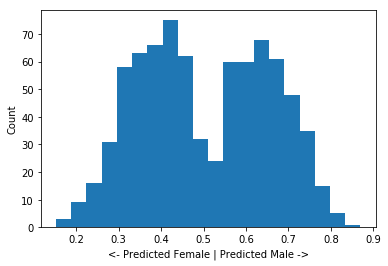

In [37]:
y_pred_prob = logistic.predict_proba(X_test)[:, 0]
plt.hist(y_pred_prob, bins=20)
plt.ylabel('Count')
plt.xlabel('<- Predicted Female | Predicted Male ->')
plt.show()

In [38]:
actual = pd.Categorical(y_test)
predicted = pd.Categorical(logistic.predict(X_test))
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,female,male,All
Actual,,,
female,375,17,392
male,15,385,400
All,390,402,792


In [39]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

      female       0.96      0.96      0.96       392
        male       0.96      0.96      0.96       400

   micro avg       0.96      0.96      0.96       792
   macro avg       0.96      0.96      0.96       792
weighted avg       0.96      0.96      0.96       792



# Decision Tree Classification

In [40]:
X = data.drop('label', axis=1)
y = data['label'].map({'male':1, 'female':0})

X_train, X_test, y_train, y_test= sklearn.model_selection.train_test_split(X, y,test_size=0.25,random_state=1)
dt = DecisionTreeClassifier(criterion='gini', random_state=2)
dt.fit(X_train,y_train)
y_pred= dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.9696969696969697

In [41]:
# Fit 'dt' to the training-set
dt.fit(X_train, y_train)
# Predict test-set labels
y_pred = dt.predict(X_test)
# Compute test-set MSE
mse_dt = mean_squared_error(y_test, y_pred)
# Compute test-set RMSE
rmse_dt = mse_dt**(1/2)
# Print rmse_dt
print(rmse_dt)

0.17407765595569785


In [42]:
predictions = dt.predict(X_test)

actual = pd.Categorical(y_test)
predicted = pd.Categorical(predictions)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,382,10,392
1,14,386,400
All,396,396,792


# K-Means Clustering

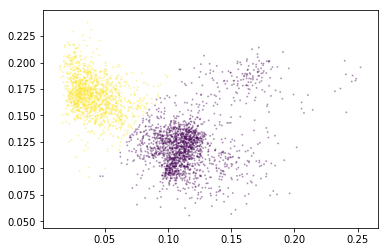

In [43]:
X = data.drop('label', axis=1)
y = data['label']

estimator = KMeans(n_clusters=2)
estimator.fit(X[['IQR', 'meanfun']])
plt.scatter(X['IQR'], X['meanfun'], c=1-estimator.labels_.astype(np.float), s=1, alpha=0.3)

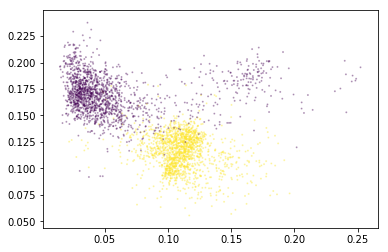

In [44]:
plt.scatter(X['IQR'], X['meanfun'], c=y.map({'male':1, 'female':0}), s=1, alpha=0.3)

# Neural Network

In [45]:
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
mlp = MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=500)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [47]:
predictions = mlp.predict(X_test)

actual = pd.Categorical(y_test)
predicted = pd.Categorical(predictions)
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,female,male,All
Actual,,,
female,380,12,392
male,13,387,400
All,393,399,792


In [48]:
mlp.score(X_test, y_test)

0.9684343434343434